# Faculty base in few Indian Institutes
> Lets' visualize

- toc: False 
- comments: true

# About

I try to understand the quality of Indian Institutes of National Importance. Of my interest are IISc, and IITs. In this quest, which ocassionally gets lots of enthusiasm, I did an excercise which I present below. You may find it particularly useful for 
* understanding the institutes on dimensions like shown in the image below
![Source: neeks](my_images/visualizing_dims.png)
* evaluating the institutes if you are a faculty aspirant
* cheering up or bringing a change

*Step 1:* I collected the NIRF 2021 data hosted by few institutes of our interest. Note that this is 2021 data, and as I understand, this has been submitted to the Ministry of Education and hence, we can consider them authentic. The NIRF 2021 rankings are yet not released.

Thanks to the meticulous data preparation by few insitutes, I could easily download this data from the institute websites. We will focus on 13 institutes. These are:
* Indian Institute of Science (iisc)
* IIT Bombay (iit_bomb), IIT Kharagpur (iit_kgp), IIT Madras (iit_mad), IIT Kanpur (iit_kan), IIT Delhi (iit_delhi), IIT Varansi (iit_bhu), IIT Roorkee (iit_roor)
* IIT Jodhpur (iit_jodhpur), IIT Indore (iit_ind), IIT Bhubaneswar (iit_bbs), IIT Mandi (iit_mandi), IIT Hyderabad (iit_hyd)

Below you can see these institute locations overlaid on a map. The idea of IIT was conceived around 1947 to enable India's technology focussed societal progress after the second world war. It was decided to create one of these in north, south, east and west of India. However, now we have them spread across many more places, with most of the states having one IIT (not all are shown in the map below). This is indeed very good as it helps to cater to the large population of India.

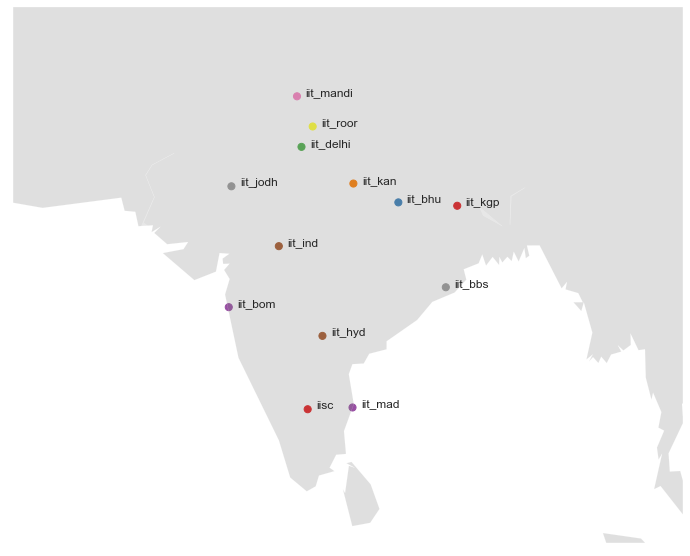

In [3]:
#collapse
import PyPDF2
import glob
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from mpl_toolkits.basemap import Basemap
import seaborn as sns
sns.set() # Use seaborn's default style to make attractive graphs
sns.set_style("white")
sns.set_style("ticks")

institutes = ['iisc','iit_kgp','iit_bhu','iit_delhi','iit_mad','iit_bom','iit_kan','iit_roor',
              'iit_ind','iit_hyd','iit_mandi','iit_jodh','iit_bbs']
# make map
geolocator = Nominatim(user_agent="geoapiExercises")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

city_names = ['bangalore', 'kharagpur','varanasi','delhi','chennai','mumbai','kanpur','roorkee',
             'indore','hyderabad','mandi','jodhpur','bhubaneswar']
df = {}
df['city_name'] = city_names
df = pd.DataFrame.from_dict(df)
df['lat'] = 0
df['long'] = 0
for i in range(len(df)):
    temp = geolocate(df['city_name'][i])
    df.loc[i,'lat'] = temp[0]
    df.loc[i,'long'] = temp[1]


# Make the india map and overlay locations
fig = plt.subplots(figsize=[12,12])
# m = Basemap(llcrnrlon=-180, llcrnrlat=-65, urcrnrlon=180, urcrnrlat=80)
m = Basemap(llcrnrlon=60, llcrnrlat=5, urcrnrlon=100, urcrnrlat=37)
m.drawmapboundary(fill_color='#FFF', linewidth=0)
m.fillcontinents(color='grey', alpha=0.25)
m.drawcoastlines(linewidth=0.1, color="white")

# prepare a color for each point depending on the continent.
df['labels_enc'] = pd.factorize(df['city_name'])[0]
 
# Add a point per position
m.scatter(x=df['long'], y=df['lat'], s=50,alpha=1, c=df['labels_enc']/100, cmap="Set1")
for i in range(len(df)):
    x = df.loc[i,'long']+0.5
    y = df.loc[i,'lat']
    plt.text(x, y, institutes[i])
plt.show()

*Step 2:* I did little bit of coding (in python) exercise to extract data from the PDF documents collected in *Step 1*. This data extract step is critical as it helps to load the data into a plotting tool!

*Step 3:* Rest is just plotting (again, using python). 

Note: I will be analyzing data of faculty at three levels, namely, Assistant, Associate, and Full Professor. Also, I have skipped the Institute Director (1 nos.) from the analysis. 

So, what do we see!

In [4]:
#collapse
# path to PDFs
path_nirf = '/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/institutes/data/nirf_pdfs/'

# some function defs
def get_curated_rows(pdfReader):
    # get faculty listing start page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Faculty Details' in lines:
            page_indx = i
            break

    all_rows = []
    for i in range(page_indx,pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        if i == page_indx:
            lines = pageObj.extractText().split('Association type')[1]
        else:
            lines = pageObj.extractText()

        line_breaks = ['Regular', 'Visiting', 'Other']
        temp = lines
        for text in line_breaks:
            temp = temp.replace(text,';')

        all_rows.extend(temp.split(';'))

    # remove contractual rows
    curated_rows = []
    for text in all_rows:
        if len(text) == 0:
            continue
        elif 'Adhoc' in text:
            temp = text.split('Adhoc /Contractual')
            for j in range(len(temp)):
                temp_1 = temp[j]
                if 'Professor' in temp_1:
                    curated_rows.append(temp_1)
        else:
            if 'Professor' in text:
                curated_rows.append(text)

    return curated_rows


def get_parsed_dict(curated_rows, code):
    # make dictionary
    keys = ['name','age','designation','gender','degree','months','joining_day',
            'joining_month','joining_year','left','institute']
    data_dict = {}
    for key in keys:
        data_dict[key] = []

    for text in curated_rows:

        # remove serial number
        for i in range(len(text)):
            if (i == 0) & (text[i]==' '):
                continue
            if not(text[i].isdigit()):
                break
        text = text[i:]

        # search name
        for i in range(len(text)):
            if text[i].isdigit():
                break
        data_dict['name'].append(text[:i])
        text = text[i:]
        
        # search age
        for i in range(len(text)):
            if not(text[i].isdigit()):
                break 
        data_dict['age'].append(int(text[:i]))
        text = text[i:]

        # search designation
        text = text.split('Professor')
        if len(text[0]) == 0:
            data_dict['designation'].append('Professor')
        else:
            data_dict['designation'].append(text[0])

        text = text[1]
        # search for gender, degree
        if 'Ph.D' in text:
            data_dict['gender'].append(text.split('Ph.D')[0])
            data_dict['degree'].append('Ph.D')
            text = text.split('Ph.D')[1]
        elif 'M.Tech' in text:
            data_dict['gender'].append(text.split('M.Tech')[0])
            data_dict['degree'].append('M.Tech')
            text = text.split('M.Tech')[1]
        elif 'B.Tech' in text:
            data_dict['gender'].append(text.split('B.Tech')[0])
            data_dict['degree'].append('B.Tech')
            text = text.split('B.Tech')[1]
        elif 'Master of Design' in text:
            data_dict['gender'].append(text.split('Master of Design')[0])
            data_dict['degree'].append('M.Des')
            text = text.split('Master of Design')[1]
        elif 'PGID' in text:
            data_dict['gender'].append(text.split('PGID')[0])
            data_dict['degree'].append('PGID')
            text = text.split('PGID')[1]
        elif 'PGDBM' in text:
            data_dict['gender'].append(text.split('PGDBM')[0])
            data_dict['degree'].append('PGDBM')
            text = text.split('PGDBM')[1]
        elif 'M.Sc.(Engg)' in text:
            data_dict['gender'].append(text.split('M.Sc.(Engg)')[0])
            data_dict['degree'].append('M.Sc.(Engg)')
            text = text.split('M.Sc.(Engg)')[1]
        elif 'M.Sc.' in text:
            data_dict['gender'].append(text.split('M.Sc.')[0])
            data_dict['degree'].append('M.Sc.')
            text = text.split('M.Sc.')[1]
        elif 'MFA(Fine Arts)' in text:
            data_dict['gender'].append(text.split('MFA(Fine Arts)')[0])
            data_dict['degree'].append('MFA(Fine Arts)')
            text = text.split('MFA(Fine Arts)')[1]
        elif 'P.G.Diploma' in text:
            data_dict['gender'].append(text.split('P.G.Diploma')[0])
            data_dict['degree'].append('P.G.Diploma')
            text = text.split('P.G.Diploma')[1]
        elif 'M. Phil' in text:
            data_dict['gender'].append(text.split('M. Phil')[0])
            data_dict['degree'].append('M. Phil')
            text = text.split('M. Phil')[1]
        elif 'M.Arch.' in text:
            data_dict['gender'].append(text.split('M.Arch.')[0])
            data_dict['degree'].append('M.Arch.')
            text = text.split('M.Arch.')[1]
        elif 'MBA' in text:
            data_dict['gender'].append(text.split('MBA')[0])
            data_dict['degree'].append('MBA')
            text = text.split('MBA')[1]
        elif 'M.A' in text:
            data_dict['gender'].append(text.split('M.A')[0])
            data_dict['degree'].append('M.A')
            text = text.split('M.A')[1]
        elif 'M.S' in text:
            data_dict['gender'].append(text.split('M.S')[0])
            data_dict['degree'].append('M.S')
            text = text.split('M.S')[1]
        elif 'M.E.' in text:
            data_dict['gender'].append(text.split('M.E.')[0])
            data_dict['degree'].append('M.E.')
            text = text.split('M.E.')[1]
        elif 'B.E' in text:
            data_dict['gender'].append(text.split('B.E')[0])
            data_dict['degree'].append('B.E')
            text = text.split('B.E')[1]

        # search months
        for i in range(len(text)):
            if (i == 0) & (text[i]==' '):
                continue
            if not(text[i].isdigit()):
                break
        data_dict['months'].append(int(text[:i]))
        text = text[i:]

        # joining date 
        for i in range(len(text)):
            if text[i].isdigit():
                break
        text = text[i:]
        data_dict['joining_day'].append(int(text.split('-')[0]))
        data_dict['joining_month'].append(int(text.split('-')[1]))
        data_dict['joining_year'].append(int(text.split('-')[2][:4]))
        
        # left or continues
        text = text.split('-')[2][4:]
        if len(text)>0:
            if text[0].isdigit():
                data_dict['left'].append(1)
        else:
            data_dict['left'].append(0)
        # institute code
        data_dict['institute'].append(code)

    return data_dict
    
def get_admin_info(pdfReader, code):
    admin_data = {}
    keys = ['PhDs_full','PhDs_part', 'staff_salaries', 'institute']
    for key in keys:
        admin_data[key] = []

    # search for PhD details page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Ph.D Student Details' in lines:
            page_indx = i
            break
    pageObj = pdfReader.getPage(i)
    lines = pageObj.extractText()
    text = lines.split("Total StudentsFull Time")[1]
    # get PhD Full time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break

    admin_data['PhDs_full'].append(int(text[:i]))
    text = text[i:].split('Part Time')[1]
    # get PhD Part time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break
    admin_data['PhDs_part'].append(int(text[:i]))

    # search for salaries page
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)
        lines = pageObj.extractText()
        if 'Salaries (Teaching and Non Teaching staff)' in lines:
            page_indx = i
            break

    pageObj = pdfReader.getPage(i)
    lines = pageObj.extractText()
    text = lines.split("Salaries (Teaching and Non Teaching staff)")[1]
    # get PhD Full time count
    for i in range(len(text)):
        if (i == 0) & (text[i]==' '):
            continue
        if not(text[i].isdigit()):
            break

    admin_data['staff_salaries'].append(int(text[:i]))
    admin_data['institute'].append(code)

    return admin_data


def remove_items(test_list, item):
      
    # using list comprehension to perform the task
    res = [i for i in test_list if i != item]
  
    return res

def name_filter(name):
    temp = name.split()
    if len(temp[0])<3:
        temp_1 = temp[1]
    else:
        if (temp[0] == 'SMT') | (temp[0] == 'Prof'):
            temp_1 = temp[1]
        else:
            temp_1 = temp[0]
    return temp_1

# main code starts here
institutes = ['iisc','iit_kgp','iit_bhu','iit_delhi','iit_mad','iit_bom','iit_kan','iit_roor',
              'iit_ind','iit_hyd','iit_mandi','iit_jodh','iit_bbs']
cnt = 0
for insitute in institutes:
    file_name = glob.glob(path_nirf+insitute+'*')[0]
    pdfFileObj = open(file_name, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    
    # get admmin df
    data = get_admin_info(pdfReader, insitute)
    df_admin_temp = pd.DataFrame.from_dict(data)
    if cnt == 0:
        df_admin = df_admin_temp.copy()
    else:
        df_admin = pd.concat([df_admin, df_admin_temp])
    
    # get faculty df
    rows = get_curated_rows(pdfReader)
    data = get_parsed_dict(rows, insitute)
    df_fac_temp = pd.DataFrame.from_dict(data)
    
    if cnt == 0:
        df_fac = df_fac_temp.copy()
    else:
        df_fac = pd.concat([df_fac, df_fac_temp])
    cnt = cnt+1

## How is the PhD Scholars count ... 

* I used to think that IITs cater mostly to undergraduate education. After seeing the plot, I was wrong. Some of the IITs have close to (or more than) 2500 PhD Scholars (in 2020). This is huge, and even more than that of IISc, a leading research institute of India. With a mix of good undergraduate and PhD Scholar population in these IITs, they are in a unique position to offer a dynamic and happening environment for research and education.
* IIT-BHU is lacking in PhD Scholars count. I don't know why. The new IITs (ii_hyd, iit_ind, iit_jodh, iit_bbs, iit_mandi) were estabkished in 2008-09, and exhibit a good count of PhD Scholars. Especially, iit_hyd is scaling up really well
* Part-time PhD Scholars are mainly in institutes located in metros (except, iit_roor). Is it because of easy accessibility?

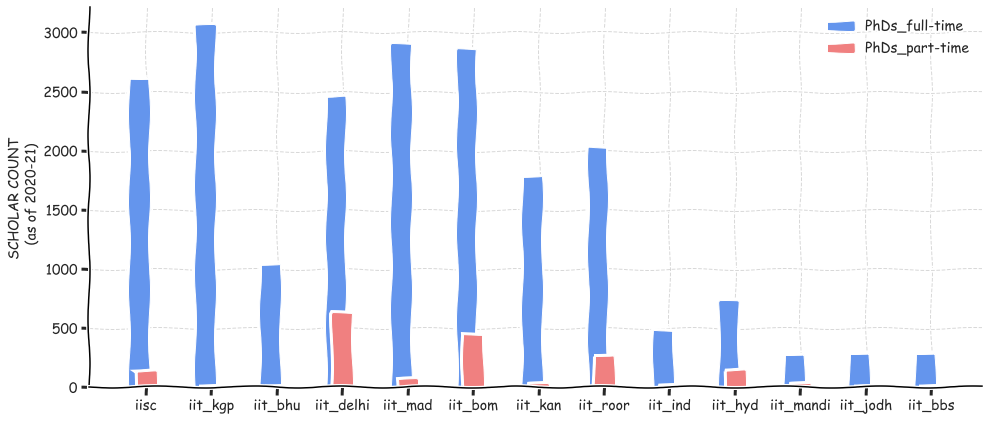

In [5]:
#collapse
# plot PhD count
data = {}
keys_1 = ['PhDs_full','PhDs_part']

        
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','lightcoral']
    for i in range(len(keys_1)):
        if i == 0:
            ax.bar(np.arange(len(institutes))+0.1*i,df_admin['PhDs_full'],width=0.3,color=clr[i],
                  label=keys_1[i]+str('-time'))
        else:
            ax.bar(np.arange(len(institutes))+0.1*i,df_admin['PhDs_part'],width=0.3,color=clr[i],
                  label=keys_1[i]+str('-time'))

    plt.xticks(np.arange(0,len(institutes))+.1,institutes,rotation=0, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.legend(frameon=False,fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('SCHOLAR COUNT \n (as of 2020-21)', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## Hows is the Faculty count...

The well established institutes have more than 400 faculty (just to remind, I am counting Asst.+Assoc.+Prof. only).

* Not all old IITs have same count of faculty. The iit_kgp and iit_bom shoot close to 700! Why is iit_kan lagging in this?
* Although IISc is lower on undergraduate student count (not shown here), the faculty strength is (relatively) quite good, at close to 450.
* Again, amongst the new IITs, iit_hyd is nicely standing tall.

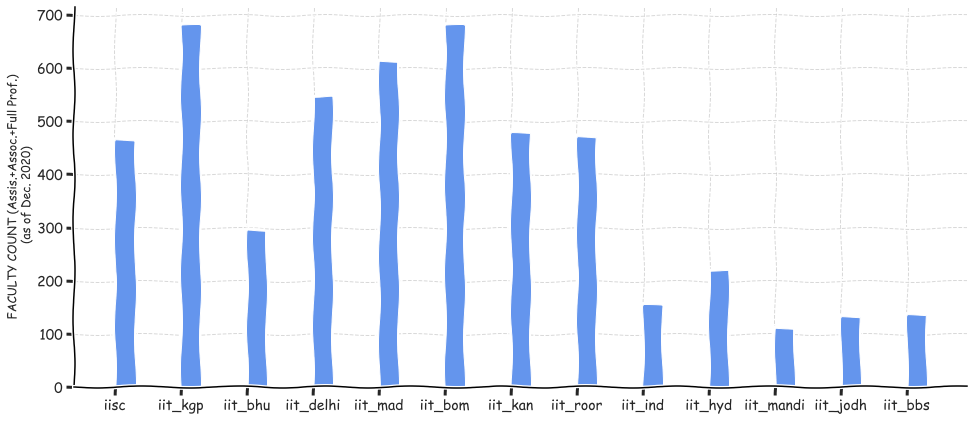

In [6]:
#collapse
# plot all salary exoense 
data = {}
keys_1 = ['staff_salaries']

val_fac_count = []
for institute in institutes:
    val_fac_count.append(len(df_fac[(df_fac['institute']==institute) & (df_fac['left']==0)]))
    
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue']
    ax.bar(np.arange(len(institutes))+0.25,val_fac_count,width=0.3,color=clr[0])
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)

    ax.set_ylabel('FACULTY COUNT (Assis.+Assoc.+Full Prof.)\n (as of Dec. 2020)')
    plt.xticks(np.arange(0,len(institutes))+.1,institutes,rotation=0, fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['top'].set_visible(False)
    ax.spines["right"].set_visible(False)
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

### Lets look at facult count and salary expense ... jointly

I collected the data on salary expense (teaching and non-teaching). I don't have information on which all staff members this includes. I still tried plotting them alongside the faculty count. As expected,  there is a positive correlation.
* Is iit_kgp being underpaid?
* or, is it that iit_mad and iisc have a huge staff count outside the faculty pool of Asst.+ Assoc.+Full Prof.

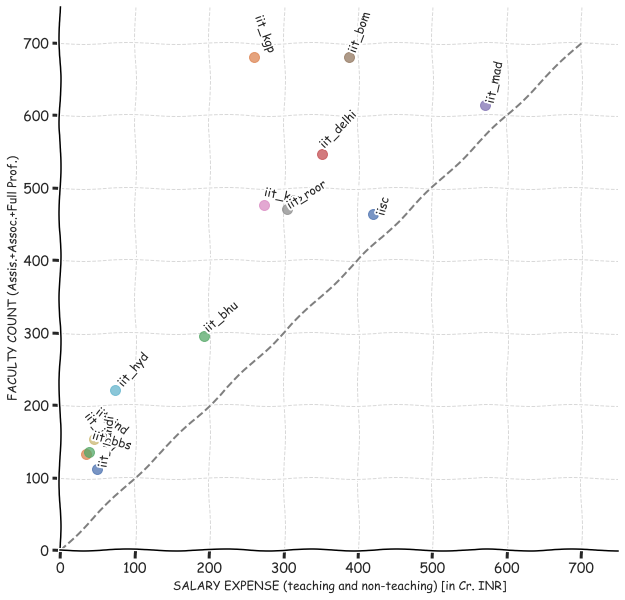

In [7]:
#collapse
# plot all salary exoense 
data = {}
keys_1 = ['staff_salaries']

val_fac_count = []
for institute in institutes:
    val_fac_count.append(len(df_fac[(df_fac['institute']==institute)& (df_fac['left']==0)]))
    
with plt.xkcd():
    fig = plt.subplots(figsize=[10,10])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','lightcoral']
    for i in range(len(institutes)):
        ax.scatter(df_admin['staff_salaries'].values[i]/1e7,val_fac_count[i],s=100,alpha=.75)
        plt.text(df_admin['staff_salaries'].values[i]/1e7+np.random.randint(-5,5),val_fac_count[i]+np.random.randint(0,10),
                 institutes[i],fontsize=FS-2, rotation=np.random.randint(-90,90))
    ax.plot([0,700],[0,700],'--',c='black',alpha=0.5)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    ax.set_xlabel('SALARY EXPENSE (teaching and non-teaching) [in Cr. INR]')
    ax.set_ylabel('FACULTY COUNT (Assis.+Assoc.+Full Prof.)')
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    ax.set_xlim([0,750])
    ax.set_ylim([0,750])
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## Lets look at age distribution of Faculty ...

I now shift gears, and plot the age distribution in the faculty pool. Some observations:
* Good spread, from 30s to 65s. In case you are not aware, the retirement age is 65.
* As expected, new IITs have a relatively younger faculty population.
* Why do iit_jodh and iit_bbs have outliers going beyond 65? We will come to this later.

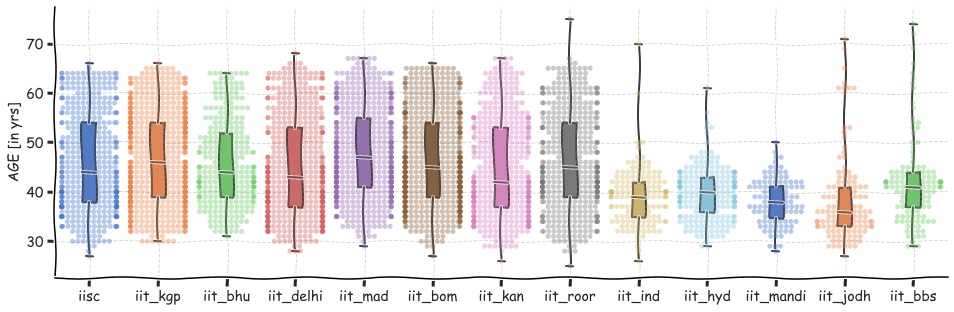

In [8]:
#collapse
# exclude faculty who have left 
df = df_fac[df_fac['left']==0].copy()
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,5])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1),palette="muted")
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4,palette="muted")
#     sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()


### How about age of just Assistant Professors ... youngistaan!


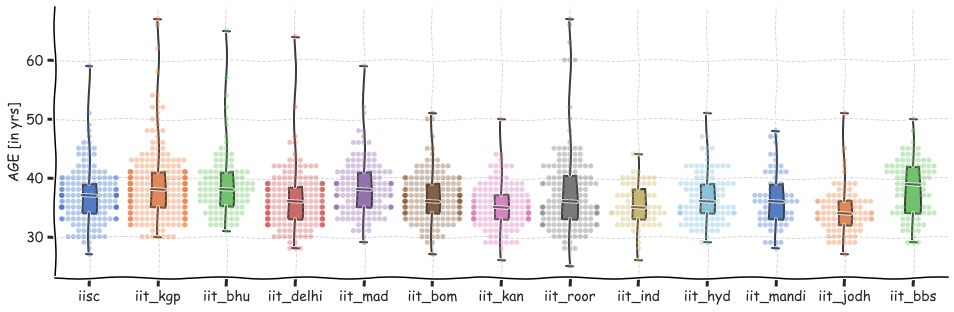

In [32]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Assistant')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,5])
    ax = plt.subplot(1,1,1)
    FS = 14
    
    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1),palette="muted")
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4,palette="muted")
#     sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()


In [31]:
df[(df['institute']=='iisc') & (df['age']>50) & (df['designation']=='Assistant')]['name']

212      Rina Maiti
233    Joy Thomas M
Name: name, dtype: object

### age of Associate Professors ...

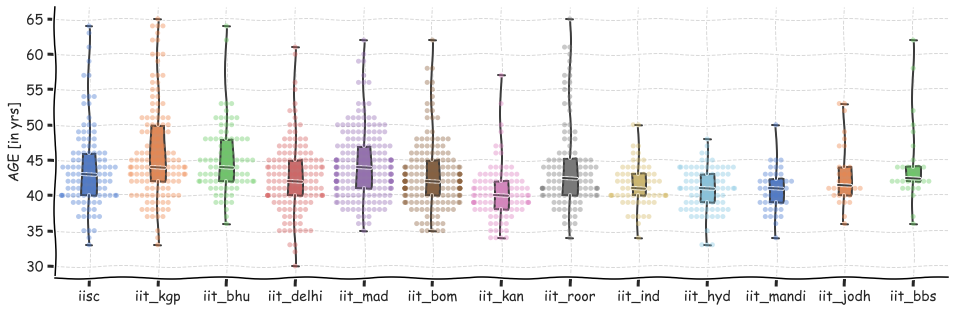

In [10]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Associate')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,5])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1),palette="muted")
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4,palette="muted")
#     sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()



### and, age of (Legendary) Professors ...

Some observations:
* iit_mandi is yet to feature a Full Professor. I have excluded the Dean here. The quality of education and research the institute has attained even without this is impressive!
* iit_jodh and iit_bbs has relatively more senior Full Professors. Even some go beyond 65. In the datasheet these are categorised as *Visiting* in the datasheet.
* iit_ind and iit_hyd feature a group of young Full Professors!

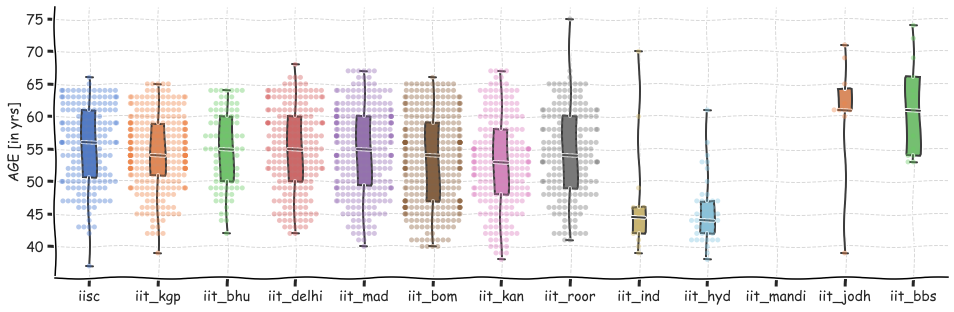

In [11]:
#collapse
# plot age (without gender)
data = {}
keys = ['age','gender','designation']
for key in keys:
    data[key] = []
    
for institute in institutes:
    for key in keys:
        data[key].append(df[(df['institute']==institute)&(df['designation']=='Professor')][key].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[16,5])
    ax = plt.subplot(1,1,1)
    FS = 14

    sns.boxplot(data = data['age'], whis = np.inf,width = 0.2,color=(.3,.8,1),palette="muted")
    sns.swarmplot(data = data['age'], color='gray',alpha=0.4,palette="muted")
#     sns.violinplot(data = data['age'], palette="muted")
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS-2)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('AGE [in yrs]', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## How is Faculty count across 3 designations ...

In Indian Academia there are three designations for a faculty position, namely, Assistant, Associate, and Full Professor. This is similar to US Academia. Lets' see how is the count across these three designations. Some observations.
* For a well established institute, (Asst. nos.) < (Assoc. nos.) < (Full Prof. nos) will likely indicate the institute is recruiting, promoting, and retiring in a timely manner! Example, iit_mad!
* Some institute recruit in burst or are not easily promoting? Example, iisc,  iit_kgp, iit_bom, iit_delhi, etc.
* New IITs, as this are being established hence, Asst. nos is higher. But wait, why are iit_bbs and iit_jodh Assoc. nos count relatively low? Is it something to do with promotions or recently, increaed recruitments? We will see that for iit_jodh atleast, the reason is the later.

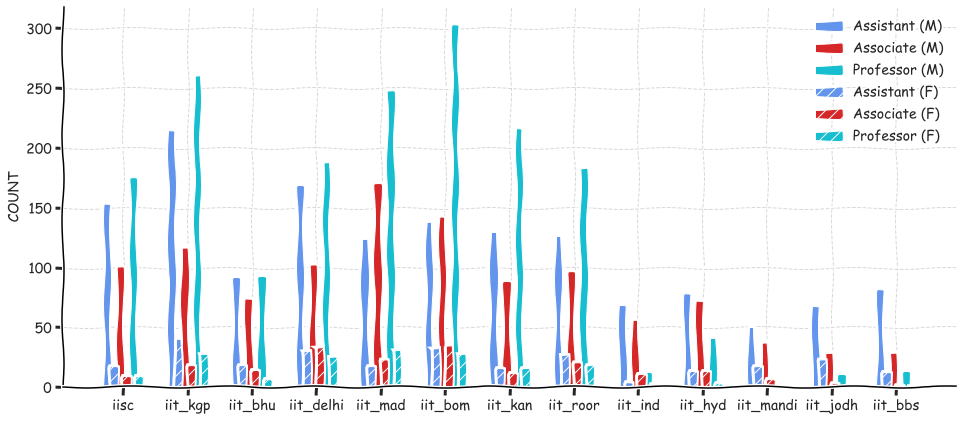

In [12]:
#collapse
# plot deisgnation (with gender)
data = {}
keys_1 = ['Male','Female']
keys_2 = ['Assistant','Associate','Professor']

for key_1 in keys_1:
    data[key_1] = {}
    for key_2 in keys_2:
        data[key_1][key_2] = []

for institute in institutes:
    for key_1 in keys_1:
        for key_2 in keys_2:
            data[key_1][key_2].append(len(df[(df['institute']==institute) &
                            (df['gender']==key_1) & (df['designation']==key_2)]))
        
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14

    clr = ['cornflowerblue','tab:red','tab:cyan']
    for i in range(len(keys_1)):
        for j in range(len(keys_2)):
            if i == 0:
                ax.bar(np.arange(len(institutes))+0.1*i+0.2*j,data[keys_1[i]][keys_2[j]],width=0.1,color=clr[j],
                      label=keys_2[j]+str(' (M)'))
            else:
                ax.bar(np.arange(len(institutes))+0.1*i+0.2*j,data[keys_1[i]][keys_2[j]],width=0.1,color=clr[j],
                       hatch='//',label=keys_2[j]+str(' (F)'))

    plt.xticks(np.arange(0,len(institutes))+.25,institutes,rotation=0, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.legend(frameon=False,fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('COUNT', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

### Look at the gender ratio ...

You would have noticed the striking difference between male and female faculty count. We can see the same story in the gender ratio.
* It is nice to see iit_mandi, and iit_jodh (the two new IITs) doing relatively better.
* New IITs, iit_hyd, iit_ind, iit_bbs, are following the old ones.
* IISc and iit_kan are the poorest in this, and iit_delhi is much better when compared to other old IITs.

A ratio > 5x is not what an institute of national importance should feature. But sadly, we see this here. Is this due to,
* Lacking quality female applicants
* Lacking intent in maintaining diversity in recruitment
* Societal conflicts causing reduced encouragement to become a faculty 
* Others

There is a need to go deeper on analyzing these aspects and address them at the earliest.

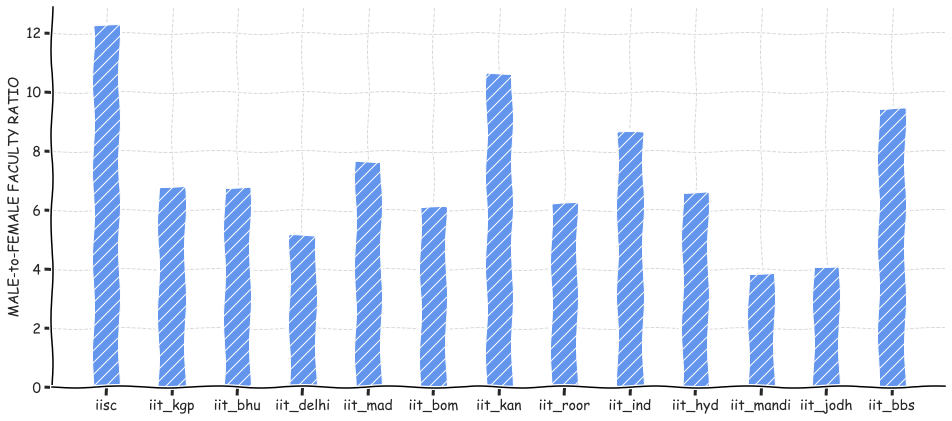

In [13]:
#collapse
# plot deisgnation (with gender)
data = {}
keys_1 = ['Male','Female']

for key_1 in keys_1:
    data[key_1] = []

for institute in institutes:
    for key_1 in keys_1:
        data[key_1].append(len(df[(df['institute']==institute) &
                        (df['gender']==key_1)]))
        
with plt.xkcd():
    fig = plt.subplots(figsize=[16,7])
    ax = plt.subplot(1,1,1)
    FS = 14
    clr = ['cornflowerblue','tab:red','tab:cyan']
    ax.bar(np.arange(len(institutes)),np.array(data[keys_1[0]])/np.array(data[keys_1[1]]),width=0.4,color=clr[0],
           hatch='//'+str(' (F)'))
    plt.xticks(np.arange(0,len(institutes)),institutes,rotation=0, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.set_ylabel('MALE-to-FEMALE FACULTY RATIO', fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    # fmt = '.pdf'
    # if fig_save:
    #     ax.figure.savefig(path_store_figure+"dicova_track_2_dur"+fmt, bbox_inches='tight')
    plt.show()

## Lets look at the joining dates of Faculty ...

I shift gears now, and look at the joining dates of faculty.

### First, we look at the year
* Something happened in 1995, and there was a gradual increase in intake
* It got reset in 1999, and again began to gradually rise till 2004.
* In 2008, with starting of new IITs, there was a rise, with signs of saturation in 2016-2017
* It picked up again in 2018.
* Welcome to 2020, the year of pandemic, the count intake reduced but thankfully, did not stop.


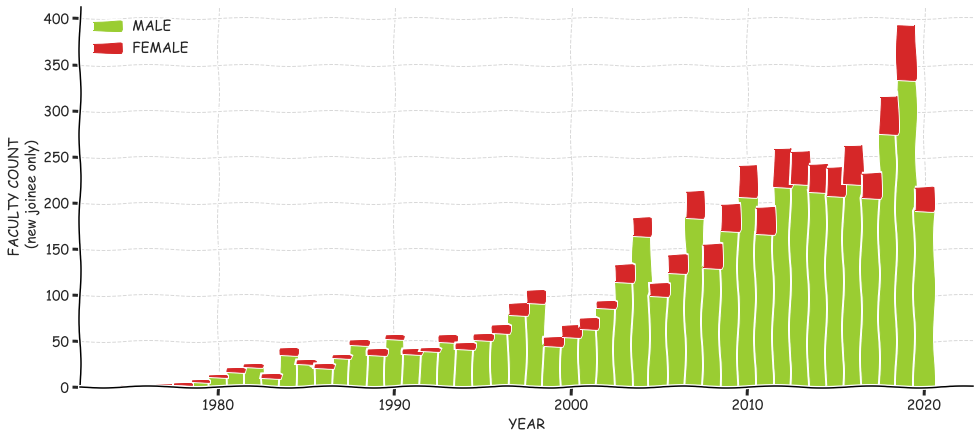

In [14]:
#collapse
# year of recruitment
# dont exclude faculty who have left 
df = df_fac.copy()
x_grid = np.arange(min(df['joining_year']),2021)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Female'))])        
with plt.xkcd():
    fig = plt.figure(figsize=[16,7])
    FS = 14
    ax = plt.subplot(1,1,1)
    clr = 'yellowgreen'
    ax.bar(x_grid,np.sum(Z_m[:,:],axis=0),alpha=1,width=1.0,
           color=clr, edgecolor=clr, label='MALE')
    clr = 'tab:red'
    ax.bar(x_grid,np.sum(Z_f[:,:],axis=0),bottom = np.sum(Z_m[:,:],axis=0), alpha=1,width=1.0,
           color=clr, edgecolor=clr, label='FEMALE')
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.ylabel('FACULTY COUNT\n (new joinee only)',fontsize=FS)
    plt.xlabel('YEAR',fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.legend(frameon=False,loc='upper left', fontsize=FS)
plt.show() 

### Breaking this across institutes ...

* Some institutes are always recruiting in good numbers (see iit_mad, and iit_kgp) and some in small numbers (see iisc).
* iit_jodh started slow, and recently, has been recruiting good numbers

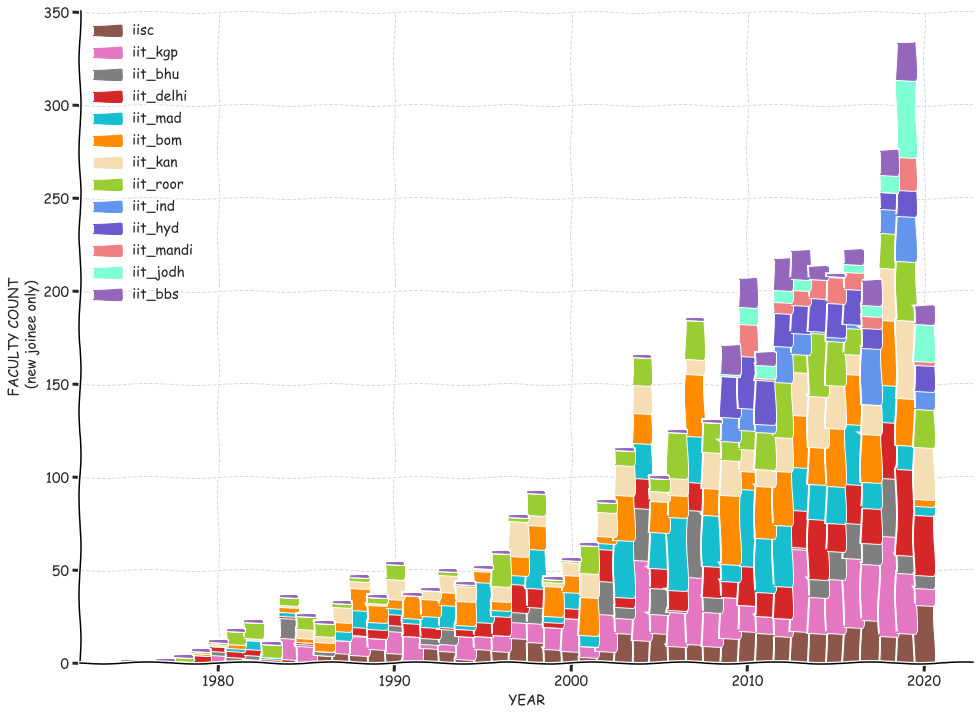

In [33]:
#collapse
# year of recruitment
x_grid = np.arange(min(df['joining_year']),2021)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Female'))])        
clr = ['tab:brown', 'tab:pink','tab:gray','tab:red','tab:cyan',
        'darkorange','wheat','yellowgreen','cornflowerblue','slateblue',
        'lightcoral','aquamarine','tab:purple']
with plt.xkcd():
    fig = plt.figure(figsize=[16,12])
    FS = 14
    ax = plt.subplot(1,1,1)
    for i in range(0,Z_m.shape[0]):
        ax.bar(x_grid,Z_m[i,:],bottom=np.sum(Z_m[:i,:],axis=0),alpha=1,width=1.0,
           color=clr[i], edgecolor=clr[i], label=institutes[i])
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.ylabel('FACULTY COUNT\n (new joinee only)',fontsize=FS)
    plt.xlabel('YEAR',fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.legend(frameon=False,loc='upper left', fontsize=FS)
plt.show() 

### Hows' the gender ratio in joinees ...

* Before 1993, the ratio was between 10-35, and highly wiggly?
* Something happened after 1995, and the ratio became stable between 5-10.
* Although, the faculty has increased since 2005 (in most institutes), this ratio has not changed much.

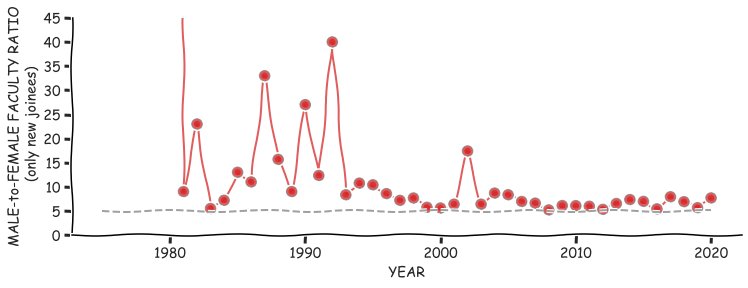

In [16]:
#collapse
# year of recruitment
x_grid = np.arange(min(df['joining_year']),2021)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_year']==x_grid[j])) & ((df['gender']=='Female'))])        
with plt.xkcd():
    fig = plt.figure(figsize=[12,4])
    FS = 14
    ax = plt.subplot(1,1,1)
    clr = 'tab:red'
    ax.plot(x_grid,np.sum(Z_m[:,:],axis=0)/(np.sum(Z_f[:,:],axis=0)+1e-3),marker='o',mec='gray',ms=10,alpha=.75,
           color='tab:red', label='ALL',linewidth=2)
    ax.plot(x_grid,5*np.ones(x_grid.shape),'--',alpha=.75,color='gray',linewidth=2)
#     plt.legend(frameon=False, loc='upper right', fontsize=FS)
    plt.ylabel('MALE-to-FEMALE FACULTY RATIO\n (only new joinees)',fontsize=FS)
    plt.xlabel('YEAR',fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    ax.set_ylim(0,45)
plt.show() 

## Which month do new faculty join?

All of these institutes have a two semester system, namely, July-Dec., and Jan-April. We expect more faculty to join during the start of these semester. This is also seen in the plots at majority of the institutes. But note, faculty also have been joining round the year.

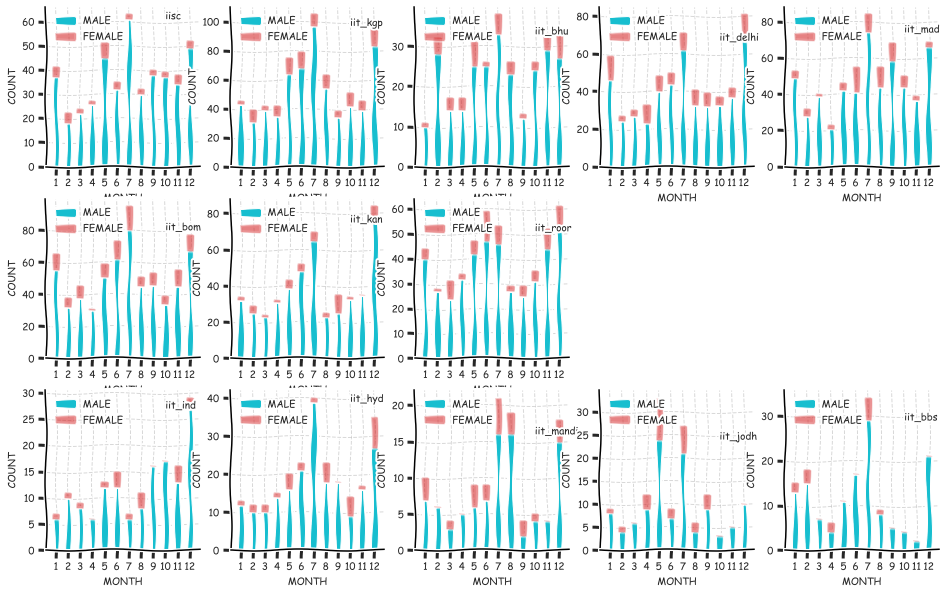

In [17]:
#collapse
# month of recruitment
x_grid = np.arange(min(df['joining_month']),max(df['joining_month'])+1)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_month']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_month']==x_grid[j])) & ((df['gender']=='Female'))])        
with plt.xkcd():
    fig = plt.figure(figsize=[16,10])
    FS = 10
    clr = 'tab:cyan'
    for i in range(Z_m.shape[0]):
            if i>7:
                ax = plt.subplot(3,5,i+3)
            else:
                ax = plt.subplot(3,5,i+1)
            ax.bar(x_grid,Z_m[i,:],color=clr,alpha=1,width=0.35,label='MALE')
            ax.bar(x_grid,Z_f[i,:],bottom=Z_m[i,:],color='tab:red',alpha=0.35,width=0.5,label='FEMALE')
            plt.legend(frameon=False,loc='upper left', fontsize=FS)
            plt.xticks(x_grid,x_grid,rotation=0, fontsize=FS)
            ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
            plt.ylabel('COUNT',fontsize=FS)
            plt.xlabel('MONTH',fontsize=FS)

            plt.xticks(fontsize=FS)
            plt.yticks(fontsize=FS)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)  
            ax.text(10,max(Z_m[i,:]),institutes[i],fontsize=FS)
    plt.show() 

## and, how about the joining day of the month ...

Is it first of the month? Yes, but again, not always!

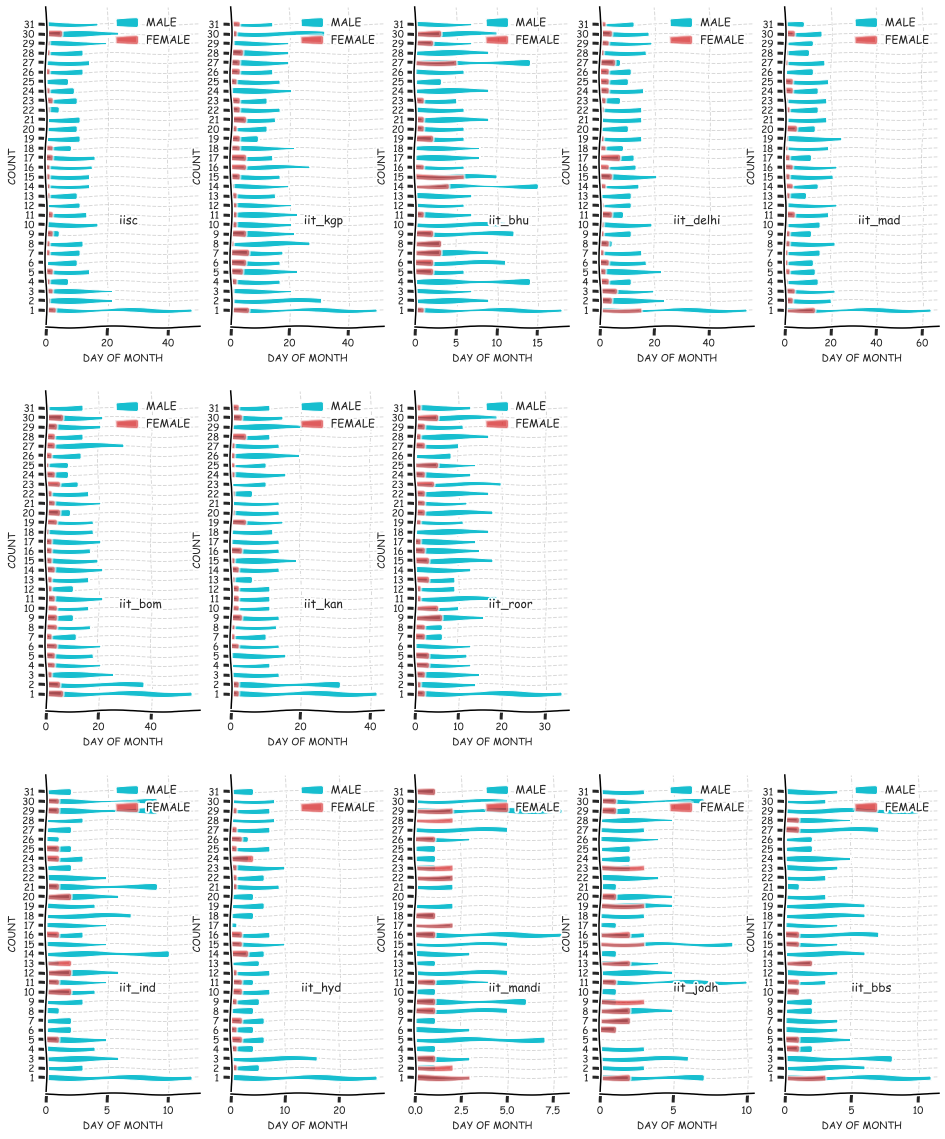

In [18]:
#collapse
# day of recruitment
x_grid = np.arange(min(df['joining_day']),max(df['joining_day'])+1)
y_grid = np.arange(0,len(institutes))

X, Y = np.meshgrid(x_grid, y_grid)
Z_m = np.zeros(X.shape)
Z_f = np.zeros(X.shape)

for i in range(len(institutes)):
    for j in range(len(x_grid)):
        Z_m[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_day']==x_grid[j])) & ((df['gender']=='Male'))])
        Z_f[i,j] = len(df[(df['institute']==institutes[i]) &
                        ((df['joining_day']==x_grid[j])) & ((df['gender']=='Female'))])        

with plt.xkcd():
    fig = plt.figure(figsize=[16,20])
    for i in range(Z_m.shape[0]):
        FS = 10
        clr = 'tab:cyan'
        if i>7:
            ax = plt.subplot(3,5,i+3)
        else:
            ax = plt.subplot(3,5,i+1)

        ax.barh(x_grid,Z_m[i,:],color=clr,alpha=1,height=0.5,label='MALE')
        ax.barh(x_grid,Z_f[i,:],color='tab:red',alpha=0.5,height=0.5,label='FEMALE')
        plt.legend(frameon=False,loc='upper right')
        plt.yticks(x_grid,x_grid,rotation=0, fontsize=FS)
        ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
        plt.ylabel('COUNT',fontsize=FS)
        plt.xlabel('DAY OF MONTH',fontsize=FS)

        plt.xticks(fontsize=FS)
        plt.yticks(fontsize=FS)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
        ax.text(max(Z_m[i,:])//2,10,institutes[i],fontsize=FS+2)
    plt.show() 

## Months (into job) versus Faculty Designation ...

I had access to the months into job data for each faculty. Below is the plot.

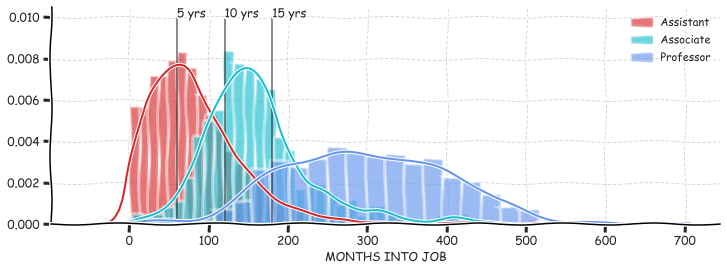

In [19]:
#collapse
vals = []
vals.append(df['months'].values)
vals.append(df['designation'].values)

with plt.xkcd():
    fig = plt.subplots(figsize=[12,4])
    ax = plt.subplot(1,1,1)
    FS = 12
    clr = 'cornflowerblue'
    sns.distplot(df[df['designation']=='Assistant']['months'],label='Assistant'
                 ,color='tab:red')
    sns.distplot(df[df['designation']=='Associate']['months'],label='Associate'
                 ,color='tab:cyan')
    sns.distplot(df[df['designation']=='Professor']['months'],label='Professor'
                 ,color='cornflowerblue')
    ax.legend(frameon=False, loc='upper right')
    ax.vlines(5*12,0,.01,color='k',alpha=0.5)
    ax.vlines(10*12,0,.01,color='k',alpha=0.5)
    ax.vlines(15*12,0,.01,color='k',alpha=0.5)
    ax.text(5*12,0.01,'5 yrs', fontsize=FS)
    ax.text(10*12,0.01,'10 yrs', fontsize=FS)
    ax.text(15*12,0.01,'15 yrs', fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xlabel('MONTHS INTO JOB',fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.show()


## Assitant Professor age during recruitment ...

For faculty aspirants, a key question is when to apply for a faculty job. Although we like to say - "age is just a number", but when it comes to faculty recruitment, usually the agre group of new joinees lies in 30-40 years. Since 2015, we can see there is peak lieing in this range, usually around 34 years.

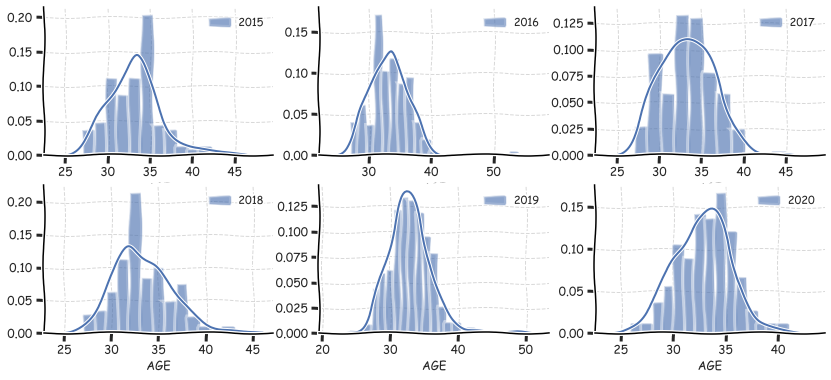

In [20]:
#collapse
vals = []
years = []
cnt = 5
for i in range(2015,2021):
    years.append(i)
    vals.append(df[(df['joining_year']==i) & (df['designation']=='Assistant')]['age'].values-cnt)
    cnt = cnt-1

with plt.xkcd():
    fig = plt.subplots(figsize=[14,6])
    FS = 12
    clr = 'cornflowerblue'
    for i in range(len(years)):
        ax = plt.subplot(2,3,i+1)
        sns.distplot(vals[i],label=str(years[i]))
        ax.legend(frameon=False, loc='upper right')
        ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
        plt.xlabel('AGE',fontsize=FS)
        plt.xticks(fontsize=FS)
        plt.yticks(fontsize=FS)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
    plt.show()



## What about starting letter of firstnames ...

While I have done basic filtering on names to remove one letter initial, Dr, Prof, SMT, or Mr, etc, still there is a caveat in this observation. All individuals and institutes don't follow the same norm while putting down their name. For example, there are few instances when surname comes before firstname. But still, lets' see the visulization.

* S is a clear winner!

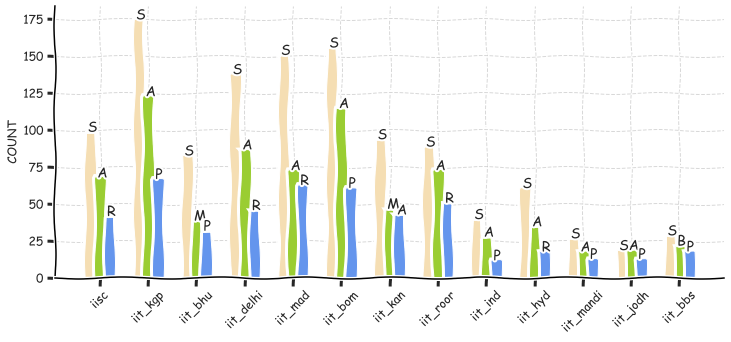

In [21]:
#collapse
data = {}
keys = ['name', 'first_char']
for key in keys:
    data[key] = []

cnt = 0
val_char = []
val_cnt = []
for institute in institutes:
    val_char.append([])
    val_cnt.append([])

    data[keys[0]].append(list(df_fac[df_fac['institute']==institute]['name'].values))
    temp = []
    for name in data[keys[0]][cnt]:
        temp.append(ord(name_filter(name)[0]))
    data[keys[1]].append(temp)
    for i in range(10):
        val_char[cnt].append(chr(max(temp,key=temp.count)))
        val_cnt[cnt].append(len(np.where(np.array(temp)==ord(val_char[cnt][i]))[0]))
        temp = remove_items(temp, ord(val_char[cnt][i]))
    cnt = cnt+1
    
with plt.xkcd():
    fig = plt.subplots(figsize=[12,5])
    ax = plt.subplot(1,1,1)
    clr = ['wheat','yellowgreen','cornflowerblue']
    for i in range(len(institutes)):
        for j in range(3):
            ax.bar(j+5*i,val_cnt[i][j],color=clr[j], width=1)
            ax.text(j+5*i-0.25,val_cnt[i][j],val_char[i][j])
    plt.xticks(np.arange(0,61,5)+1,institutes,rotation=45, fontsize=FS)
    ax.grid(color='gray', linestyle='--', linewidth=1,alpha=.3)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    plt.ylabel('COUNT',fontsize=FS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()

## Thats' all for now.

* If you have suggestion or interpretations ....feel free to comment below or email me.
